# Imports


In [3]:
import csv
import os
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle
import random
import dask.dataframe as dd
from collections import defaultdict
from dataclasses import dataclass
from zipfile import ZipFile
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
import spacy


In [4]:
print('Max cpu detected: {}'.format(multiprocessing.cpu_count()))
#npartitions = multiprocessing.cpu_count()

Max cpu detected: 2


In [5]:
if tf.config.list_physical_devices('GPU'):
    print('GPU available')
else:
    print('No GPU detected...when it comes to training please set the accelerator to use a GPU')

GPU available


In [ ]:
data_path = '/content/drive/MyDrive/TFG/training.1600000.processed.noemoticon.csv'

@dataclass
class CONFIG():
  """
  """
  col_names = ["target", "ids", "date", "flag", "user", "text"]
  embedding_dim = 300
  maxlen = 50
  vocab_size = 200000
  truncating = 'post'
  padding = 'post'
  oov_token = '<OOV>'
  max_examples = 160000
  training_split = .9

Config = CONFIG()

data = pd.read_csv(data_path,
                   names = CONFIG.col_names,
                   encoding = "ISO-8859-1")

print('Dataset size {}'.format(len(data)))
print('Dataset first five rows:\n{}'.format(data.head()))

Dataset size 1600000
Dataset first five rows:
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


# PREPROCESS

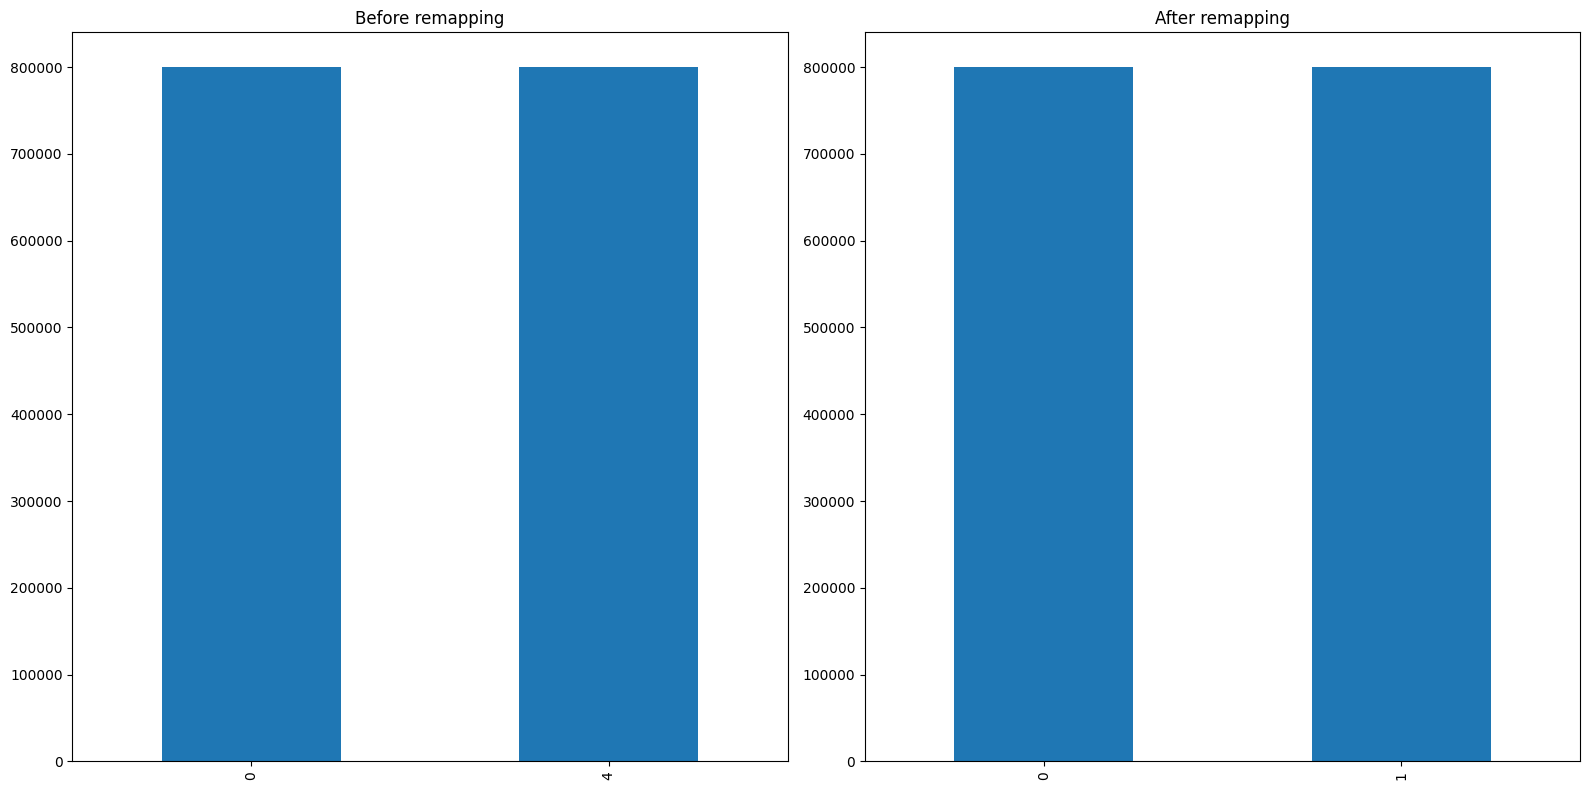

In [ ]:
#Change de values = 4 for = 1
fig, (ax1, ax2) = plt.subplots(ncols=2,
                               figsize = (16, 8))

data.target.value_counts().plot(kind = 'bar', ax = ax1)
ax1.set_title('Before remapping')
data.target = data.target.map({0 : 0,
                               4 : 1})
data.target.value_counts().plot(kind = 'bar', ax = ax2)
ax2.set_title('After remapping')
plt.tight_layout()     

In [ ]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words #DefaultStopWords
stop_list = stop_words.union(set(string.punctuation)) #stopList
porter = nltk.stem.PorterStemmer() #Stemming

# preprocessing pipeline
def preprocess(text):
    text = re.sub("https?:\S+|http?:\S|[0-9]+", '', text) #NoLiks
    text = re.sub("\.{2,}", '', text) #NoElipse
    text = re.sub('@[^\s]+', '', text)  # remove usernames
    text = re.sub('\[.*?\]', '', text)  # remove square brackets and contents
    text = re.sub('\s{2,}', ' ', text)  # remove extra spaces
    doc = nlp(text) #doc object:documento de texto procesado por una biblioteca de NLP
    tokens = [word.lemma_.lower() for word in doc if not word.is_stop and not word.is_punct and not word.is_space and not word.is_digit] #check if is not an stop & lower & lemma: basic form 
    tokens = [porter.stem(token) for token in tokens] #stem: raiz
    return tokens
    #return ' '.join(tokens)

In [ ]:
test = data.head()
test = test['text'].apply(lambda x: preprocess(x))
print('Before: {}'. format(list(data['text'][:5])))
print('After: {}'. format(list(test[:5])))

Before: ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 'my whole body feels itchy and like its on fire ', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
After: [['awww', 'bummer', 'shoulda', 'get', 'david', 'carr', 'day', ';d'], ['upset', 'updat', 'facebook', 'text', 'cri', 'result', 'school', 'today', 'blah'], ['dive', 'time', 'ball', 'manag', 'save', 'rest', 'bound'], ['bodi', 'feel', 'itchi', 'like', 'fire'], ['behav', 'mad']]


In [ ]:
def preprocess_df(dd:object):
  dd['text'] = dd['text'].map(lambda x: preprocess(x))

  return dd

In [ ]:
data = data.drop(['ids', 'date', 'flag','user'], axis = 1) #delate not use col

In [ ]:
X, y  = data['text'].tolist(), data.pop('target').to_numpy() 

'''
data['text'].tolist() returns a list of all the values in the "text" column of the data DataFrame, and assigns it to X.

data.pop('target').to_numpy() removes the "target" column from the data DataFrame, assigns it to y, and returns it as a NumPy array.
'''

'\ndata[\'text\'].tolist() returns a list of all the values in the "text" column of the data DataFrame, and assigns it to X.\n\ndata.pop(\'target\').to_numpy() removes the "target" column from the data DataFrame, assigns it to y, and returns it as a NumPy array.\n'

In [ ]:
# X = [preprocess(text) for text in X] #preprocesses each text document in the list X

In [ ]:
# import cupy as cp

#X_cupy = cp.asarray(X) # copy X to GPU memory

#total = len(X_cupy)
#for i, text in enumerate(X_cupy):
#    X_cupy[i] = preprocess(text.get())
#    print('Processed {} out of {} documents ({:.1%})'.format(i+1, total, (i+1)/total))

# X = X_cupy.get() # copy X back to CPU memory

In [ ]:
total = len(X)
for i, text in enumerate(X):
    X[i] = preprocess(text)
    print('Processed {} out of {} documents ({:.1%})'.format(i+1, total, (i+1)/total))

Se han truncado las últimas 5000 líneas del flujo de salida.
Processed 1595001 out of 1600000 documents (99.7%)
Processed 1595002 out of 1600000 documents (99.7%)
Processed 1595003 out of 1600000 documents (99.7%)
Processed 1595004 out of 1600000 documents (99.7%)
Processed 1595005 out of 1600000 documents (99.7%)
Processed 1595006 out of 1600000 documents (99.7%)
Processed 1595007 out of 1600000 documents (99.7%)
Processed 1595008 out of 1600000 documents (99.7%)
Processed 1595009 out of 1600000 documents (99.7%)
Processed 1595010 out of 1600000 documents (99.7%)
Processed 1595011 out of 1600000 documents (99.7%)
Processed 1595012 out of 1600000 documents (99.7%)
Processed 1595013 out of 1600000 documents (99.7%)
Processed 1595014 out of 1600000 documents (99.7%)
Processed 1595015 out of 1600000 documents (99.7%)
Processed 1595016 out of 1600000 documents (99.7%)
Processed 1595017 out of 1600000 documents (99.7%)
Processed 1595018 out of 1600000 documents (99.7%)
Processed 1595019 out

In [ ]:
processed = [(X[i], y[i]) for i, text in enumerate(X)]

In [ ]:
print('Post preprocessing check: {}'.format(list(X[:5])))

Post preprocessing check: [['awww', 'bummer', 'shoulda', 'get', 'david', 'carr', 'day', ';d'], ['upset', 'updat', 'facebook', 'text', 'cri', 'result', 'school', 'today', 'blah'], ['dive', 'time', 'ball', 'manag', 'save', 'rest', 'bound'], ['bodi', 'feel', 'itchi', 'like', 'fire'], ['behav', 'mad']]


In [ ]:
with open('/content/drive/MyDrive/TFG/data_processed.pkl', 'wb') as f:
  pickle.dump(processed, f)

# Load PreProcessed data
Before execute Confing and imports



In [6]:
@dataclass
class CONFIG():
  """
  """
  col_names = ["target", "ids", "date", "flag", "user", "text"]
  embedding_dim = 300
  maxlen = 50
  vocab_size = 200000
  truncating = 'post'
  padding = 'post'
  oov_token = '<OOV>'
  max_examples = 160000
  training_split = .9

Config = CONFIG()

In [ ]:
# Load processed tweets with target data
with open('/content/drive/MyDrive/TFG/data_processed.pkl', 'rb') as f:
  processed = pickle.load(f)

print('Processed data: {}'.format(processed[0]))

X, y = zip(*processed)

Processed data: (['awww', 'bummer', 'shoulda', 'get', 'david', 'carr', 'day', ';d'], 0)


In [ ]:
print(len(X))#tokenized comment
print(len(y))#polarity

1600000
1600000


In [ ]:
# Split in training validation and test sets
X_train, X_test, y_train, y_test = test = train_test_split(X, y,
                                                           shuffle = True, 
                                                           random_state=1, 
                                                           test_size = 100000,
                                                           stratify = y)

print('Train/val size is {}'.format(len(X_train))) 
print('Test size is {}'.format(len(X_test))) 
print('Example train/val comment: {}'.format(X_train[:1]))
print('Example test comment: {}'.format(X_test[:1]))

Train/val size is 1500000
Test size is 100000
Example train/val comment: [['offic', 'way', 'cold', 'summer', 'use', 'heater', 'freez']]
Example test comment: [['wait', 'coffe', 'kingston', 'pour', 'rain']]
